In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


---

**Load essential libraries**

---

In [2]:
## Load modules

# Standard modules
import pandas as pd
import numpy as np
import sys

# Preprocessing modules
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler,\
 OneHotEncoder, LabelEncoder

# Train-test split module
from sklearn.model_selection import train_test_split

# Dimension reduction module
from sklearn.decomposition import PCA

# Classifier module
from sklearn.ensemble import GradientBoostingClassifier


# Pipeline modules
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Performance metric modules
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.style.use('dark_background')
%matplotlib inline
plt.rcParams['figure.figsize'] = (4.0, 4.0) # set default size of plots

pd.options.display.max_columns = None

In [ ]:
## Mount Google drive folder if running in Colab
if('google.colab' in sys.modules):
    from google.colab import drive
    drive.mount('/content/drive', force_remount = True)
    # Change path below starting from /content/drive/MyDrive/Colab Notebooks/
    # depending on how data is organized inside your Colab Notebooks folder in
    # Google Drive
    DIR = '/content/drive/MyDrive/Colab Notebooks/MAHE/MSIS Coursework/OddSem2024MAHE'
    DATA_DIR = DIR+'/Data/'
else:
    DATA_DIR = 'Data/'

---

Load ICU Data

---

In [3]:
## Load ICU Data
file = '/content/drive/MyDrive/BDA_1_Sem/APS/APS_Lab/Data/ICU_Complete.csv'
dfICU = pd.read_csv(file)
dfICU.head(5)

,Length_of_stay,In-hospital_death,Age,Gender,Height,DiasABP_first,Glucose_first,HR_first,Temp_first,PaCO2_first,PaO2_first,Platelets_first,WBC_first,Weight,MechVent
0,8,No,76,Male,175.3,67,105,88.0,35.2,34,344,164,7.4,80.6,Yes
1,6,Yes,78,Female,162.6,50,132,111.0,38.0,30,128,91,16.1,48.4,Yes
2,8,No,74,Male,175.3,51,106,67.0,34.8,42,486,141,9.0,66.1,Yes
3,7,No,71,Female,157.5,60,132,84.0,35.5,35,245,120,13.7,55.8,Yes
4,11,No,78,Male,167.6,57,90,73.0,34.7,40,281,121,12.5,72.4,Yes


---

Drop the 'In-hospital_death' and 'Length_of_stay' columns as we will develop a prospective model which takes as input information available at the time of patient admission and will predict whether a patient will need mechanical ventilation or not.

---

In [4]:
## Drop the 'In-hospital_death' and 'Length_of_stay' columns
dfICU.drop(['In-hospital_death', 'Length_of_stay'], axis = 1, inplace = True) # retorspective

In [6]:
dfICU.head(5)

,Age,Gender,Height,DiasABP_first,Glucose_first,HR_first,Temp_first,PaCO2_first,PaO2_first,Platelets_first,WBC_first,Weight,MechVent
0,76,Male,175.3,67,105,88.0,35.2,34,344,164,7.4,80.6,Yes
1,78,Female,162.6,50,132,111.0,38.0,30,128,91,16.1,48.4,Yes
2,74,Male,175.3,51,106,67.0,34.8,42,486,141,9.0,66.1,Yes
3,71,Female,157.5,60,132,84.0,35.5,35,245,120,13.7,55.8,Yes
4,78,Male,167.6,57,90,73.0,34.7,40,281,121,12.5,72.4,Yes


---

Create lists of categorical and continuous features

---

In [5]:
## Create lists of categorical and continuous features
categorical_features = ['Gender', 'MechVent']
continuous_features = dfICU.columns[~dfICU.columns.isin(categorical_features)].to_list()
dfICU.dtypes

,0
Age,int64
Gender,object
Height,float64
DiasABP_first,int64
Glucose_first,int64
HR_first,float64
Temp_first,float64
PaCO2_first,int64
PaO2_first,int64
Platelets_first,int64


---

Convert categorical features to the categorical type

---

In [7]:
dfICU[categorical_features] = dfICU[categorical_features].astype('category')
dfICU.dtypes

,0
Age,int64
Gender,category
Height,float64
DiasABP_first,int64
Glucose_first,int64
HR_first,float64
Temp_first,float64
PaCO2_first,int64
PaO2_first,int64
Platelets_first,int64


---

How balanced is the dataset w.r.t. the target variable 'MechVent'?

---

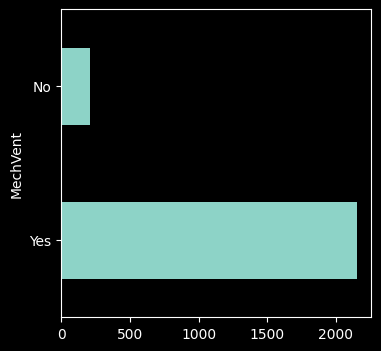

In [8]:
## How balanced is the dataset w.r.t. the target variable 'MechVent'?
dfICU['MechVent'].value_counts().plot(kind = 'barh');

---

Remove the target variable 'MechVent' from the list of categorical features

---

In [9]:
## Remove the target variable 'MechVent' from the list of categorical features
categorical_features.remove('MechVent')

---

Stratified train and test split of the data

---

In [10]:
dfICU.dtypes

,0
Age,int64
Gender,category
Height,float64
DiasABP_first,int64
Glucose_first,int64
HR_first,float64
Temp_first,float64
PaCO2_first,int64
PaO2_first,int64
Platelets_first,int64


In [11]:
## Stratified train and test split of the data
X = dfICU.drop('MechVent', axis = 1)
y = dfICU['MechVent']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify = y, #propation of
                                                    test_size = 0.2,
                                                    random_state = 1)
print(f'{X_train.shape[0]} training samples and {X_test.shape[0]} test samples')

1889 training samples and 473 test samples


In [12]:
print(np.mean(y_train == 'No'))
print(np.mean(y_train == 'Yes'))

print(np.mean(y_test == 'No'))
print(np.mean(y_test == 'Yes'))

0.0884065643197459
0.9115934356802541
0.08879492600422834
0.9112050739957717


---

Build preprocessing pipeline for categorical and continuous features


---

In [16]:
## Build pipeline for continuous and categorical features

# Pipeline object for continuous features
continuous_transformer = Pipeline(steps = [('scaler', StandardScaler()),
                                           ('pca', PCA(n_components = 2))])

# Pipeline object for categorical features
categorical_transformer = Pipeline(steps = [('onehotenc', OneHotEncoder(handle_unknown = 'ignore'))])


# Create a preprocessor object for all features
preprocessor = ColumnTransformer(transformers = [('continuous', continuous_transformer, continuous_features),
                                                 ('categorical', categorical_transformer, categorical_features)
                                                 ],
                                 remainder = 'passthrough'
                                 )

# Define a classifier object
classifier = GradientBoostingClassifier()

# Define the entire classification model
model = Pipeline(steps = [('preprocessor', preprocessor), ('classifier', classifier)])

In [15]:
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('continuous',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=7))]),
                                                  ['Age', 'Height',
                                                   'DiasABP_first',
                                                   'Glucose_first', 'HR_first',
                                                   'Temp_first', 'PaCO2_first',
                                                   'PaO2_first',
                                                   'Platelets_first',
                                                   'WBC_first', 'Weight']),
                                                 ('categorical',
                                                  Pipeline(steps=[('onehotenc',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Gender'])])),
                ('classifier', GradientBoostingClassifier())])

---

Fit the model on the train data and test on the test data

---

In [17]:
## Fit the model on the train data and test on the test data
model.fit(X_train, y_train)

# Predict the output labels for the test set
y_pred = model.predict(X_test)
print(confusion_matrix(y_test, y_pred))

[[  0  42]
 [  3 428]]


Oral Cancer

In [43]:
dfOralCancer = pd.read_csv('/content/drive/MyDrive/BDA_1_Sem/APS/APS_Lab/Data/OralCancerData.csv', index_col=0)
dfOralCancer.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021

In [44]:
dfOralCancer.shape

(135, 1025)

In [45]:
dfOralCancer.dtypes

,0
0,float64
1,float64
2,float64
3,float64
4,float64
...,...
1020,float64
1021,float64
1022,float64
1023,float64


In [46]:
continuous_features = dfOralCancer.columns.to_list()
continuous_features.remove('Label')
continuous_features

['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '50',
 '51',
 '52',
 '53',
 '54',
 '55',
 '56',
 '57',
 '58',
 '59',
 '60',
 '61',
 '62',
 '63',
 '64',
 '65',
 '66',
 '67',
 '68',
 '69',
 '70',
 '71',
 '72',
 '73',
 '74',
 '75',
 '76',
 '77',
 '78',
 '79',
 '80',
 '81',
 '82',
 '83',
 '84',
 '85',
 '86',
 '87',
 '88',
 '89',
 '90',
 '91',
 '92',
 '93',
 '94',
 '95',
 '96',
 '97',
 '98',
 '99',
 '100',
 '101',
 '102',
 '103',
 '104',
 '105',
 '106',
 '107',
 '108',
 '109',
 '110',
 '111',
 '112',
 '113',
 '114',
 '115',
 '116',
 '117',
 '118',
 '119',
 '120',
 '121',
 '122',
 '123',
 '124',
 '125',
 '126',
 '127',
 '128',
 '129',
 '130',
 '131',
 '132',
 '133',
 '134',
 '135',
 '136',
 '137',
 '138'

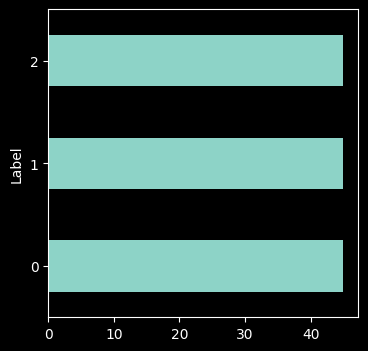

In [23]:
dfOralCancer['Label'].value_counts().plot(kind = 'barh');

In [78]:
## Stratified train and test split of the data
X = dfOralCancer[continuous_features]
y = dfOralCancer['Label'].astype('category')
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2)
print(f'{X_train.shape[0]} training samples and {X_test.shape[0]} test samples')

108 training samples and 27 test samples


In [52]:
## Build pipeline for continuous and categorical features

# Pipeline object for continuous features
continuous_transformer = Pipeline(steps = [('scaler', StandardScaler()),
                                           ('pca', PCA(n_components = 2))])

# Pipeline object for categorical features
#categorical_transformer = Pipeline(steps = [('onehotenc', OneHotEncoder(handle_unknown = 'ignore'))])


# Create a preprocessor object for all features
preprocessor = ColumnTransformer(transformers = [('continuous', continuous_transformer, continuous_features)#,
                                                 #('categorical', categorical_transformer, categorical_features)
                                                 ],
                                 remainder = 'passthrough'
                                 )

# Define a classifier object
#classifier = GradientBoostingClassifier()

# Define the entire classification model
model = Pipeline(steps = [('preprocessor', preprocessor)]) #('classifier', classifier)])

In [53]:
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('continuous',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=2))]),
                                                  ['0', '1', '2', '3', '4', '5',
                                                   '6', '7', '8', '9', '10',
                                                   '11', '12', '13', '14', '15',
                                                   '16', '17', '18', '19', '20',
                                                   '21', '22', '23', '24', '25',
                                                   '26', '27', '28', '29', ...])]))])

In [79]:
## Fit the model on the train data and test on the test data
model.fit(X_train,y_train)
# Predict the output labels for the test set
X_transform = model.transform(X_test)
X_transform[:,:2]

array([[ 8.19432775e+01,  5.33348096e+01],
       [ 2.67205566e+01,  1.74197664e+01],
       [-3.31792763e+00, -8.71037638e-01],
       [ 7.43888884e+01,  3.28754075e+01],
       [ 3.48198558e+00, -1.52976096e+01],
       [ 2.36314588e+01, -4.84474797e+00],
       [ 1.78817814e+01,  2.19364693e+01],
       [-2.40034012e+01,  1.78470219e+01],
       [ 1.00697805e+01, -2.05863362e+01],
       [-5.72884443e+00,  5.00336937e+00],
       [-2.76385596e+01, -4.23488984e+00],
       [-1.90608155e+01,  2.84594032e+00],
       [ 4.06563329e+00, -1.25575011e-01],
       [ 2.21698076e+01, -6.53025239e+00],
       [ 5.99491597e+01,  2.29086569e+01],
       [-1.55254651e+01,  4.52305779e+00],
       [-2.31802298e+01, -8.61004001e+00],
       [-6.53997161e+00,  1.81348012e+00],
       [ 1.77982725e+01, -5.45726813e+00],
       [ 8.24172384e+00,  8.44392042e+00],
       [-6.64595295e+00, -1.43593038e+01],
       [ 5.37135568e+00, -8.97367442e+00],
       [-5.38542015e+00,  2.31743588e+01],
       [ 8.

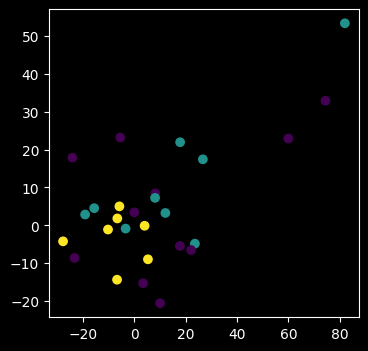

In [80]:
plt.scatter(X_transform[:,0], X_transform[:,1], c = y_test)

In [65]:
## Stratified train and test split of the data
X1 = dfOralCancer[continuous_features]
y1 = dfOralCancer['Label'].astype('category')
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1,
                                                    test_size = 0.2)
print(f'{X_train.shape[0]} training samples and {X_test.shape[0]} test samples')

108 training samples and 27 test samples


In [66]:
## Build pipeline for continuous and categorical features

# Pipeline object for continuous features
continuous_transformer = Pipeline(steps = [('scaler', StandardScaler()),
                                           ('pca', PCA(n_components = 0.75))])

# Pipeline object for categorical features
#categorical_transformer = Pipeline(steps = [('onehotenc', OneHotEncoder(handle_unknown = 'ignore'))])


# Create a preprocessor object for all features
preprocessor = ColumnTransformer(transformers = [('continuous', continuous_transformer, continuous_features)#,
                                                 #('categorical', categorical_transformer, categorical_features)
                                                 ],
                                 remainder = 'passthrough'
                                 )

# Define a classifier object
#classifier = GradientBoostingClassifier()

# Define the entire classification model
model = Pipeline(steps = [('preprocessor', preprocessor)]) #('classifier', classifier)])

In [73]:
model.fit(X_train1,y_train1)
# Predict the output labels for the test set
X_transform1 = model.transform(X_test1)
X_transform1[:,:]

array([[ 22.60864896, -22.96696597],
       [ 86.22567638,  52.06285111],
       [-22.37983631,   6.4857045 ],
       [ -5.06297162,  -7.23589458],
       [ -0.19951965,  -1.59708169],
       [ -0.36572008,  -0.21185534],
       [  9.29032682,   8.11116271],
       [ 25.41013756,  -5.80532603],
       [ 28.82328713, -10.66700457],
       [ -2.70440306,  -4.59351812],
       [ -1.46526549,  -1.69455707],
       [-13.95294551,   4.53012368],
       [ 63.65848415,  18.98626275],
       [ 13.02747233,  19.1763786 ],
       [102.78844802,  21.46176003],
       [ -6.56856684, -37.97623917],
       [ 19.14444772,  -7.49834376],
       [  4.39631042, -16.90525841],
       [-23.58946352, -10.22287567],
       [ 48.79323434, -26.25787093],
       [-11.87932441,  -8.04699403],
       [ -1.07774501,  -1.21534015],
       [  5.12252119,  -0.74816034],
       [ -2.11579543,  -5.37779736],
       [-25.30374689, -10.56929547],
       [ 18.05521258,  17.37146079],
       [ 10.09064309,  16.57157645]])

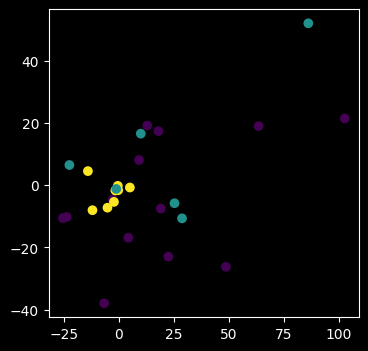

In [77]:
plt.scatter(X_transform1[:,0], X_transform1[:,1], c = y_test1)